In [1]:
# !pip install timezonefinder 
# !pip install datetime
# !pip install pytz
# !pip install apache-beam 
# !pip install google-cloud-dataflow

In [29]:
# import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

%matplotlib inline

In [31]:
import data
import csv

SyntaxError: invalid syntax (<ipython-input-31-ce6815a3c8b7>, line 1)

ファイルからid,緯度経度を抽出

In [11]:
with beam.Pipeline('DirectRunner') as pipeline:

  # データの読み込み、フィルタリング
  airports=(pipeline
            | beam.io.ReadFromText('airports.csv.gz')
            | beam.Map(lambda line:next(csv.reader([line])))
            # 空港のid,緯度、経度のcolumnのみ取得
            | beam.Map(lambda fields : (fields[0],(fields[21],fields[26])))
           )

  # データのパース、書き込み
  airports | beam.Map(lambda (airport,data):'{},{}'.format(airport,','.join(data))) | beam.io.textio.WriteToText('extracted_airports')

  pipeline.run()

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-21 03:23:34.334799. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


緯度経度からtimezoneを変換

In [3]:
def add_timezone(lat,lon):
  try:
    # 内部でimport するのはDataflowだと推奨されている
    # https://cloud.google.com/dataflow/faq
    import timezonefinder
    tf=timezonefinder.TimezoneFinder()
    tz=tf.timezone_at(lng=float(lon),lat=float(lat))
    
    if tz is None:
      tz='UTC'
    return (lat,lon,tz)
  
  except ValueError:
    return(lat,lon,'TIMEZONE')

In [6]:
with beam.Pipeline('DirectRunner') as pipeline:

  # データの読み込み、フィルタリング
  airports=(pipeline
            | beam.io.ReadFromText('airports.csv.gz')
            # headerは飛ばす
            | beam.Map(lambda line:next(csv.reader([line])))
            # 空港のid,緯度、経度のcolumnのみ取得し、tzに変換
            | beam.Map(lambda fields : (fields[0],add_timezone(fields[21],fields[26])))
           )

  # データのパース、書き込み
  airports | beam.Map(lambda (airport,data):'{},{}'.format(airport,','.join(data))) | beam.io.textio.WriteToText('extracted_airports')

  pipeline.run()

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-21 02:41:25.616323. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [61]:
%storage --h

usage: storage [-h] {copy,create,delete,list,read,view,write} ...

Execute various storage-related operations. Use "%storage <command> -h" for
help on a specific command.

positional arguments:
  {copy,create,delete,list,read,view,write}
                        commands
    copy                Copy one or more GCS objects to a different location.
    create              Create one or more GCS buckets.
    delete              Delete one or more GCS buckets or objects.
    list                List buckets in a project, or contents of a bucket.
    read                Read the contents of a storage object into a Python
                        variable.
    view                View the contents of a storage object.
    write               Write the value of a Python variable to a storage
                        object.

optional arguments:
  -h, --help            show this help message and exit
None


In [10]:
%storage create -b gs://flights-data-bucket

In [11]:
# GCSに予め保存した離着陸データを取得
%storage list

Bucket,Created
gs://csv-data-bucket,2018-04-15 11:56:35.082000+00:00
gs://data-science-on-the-gcp.appspot.com,2018-04-15 11:54:22.540000+00:00
gs://flights-data-bucket,2018-05-21 11:00:49.474000+00:00
gs://staging.data-science-on-the-gcp.appspot.com,2018-04-15 11:54:22.648000+00:00


In [68]:
%storage list -b  gs://csv-data-bucket

Name,Type,Size,Updated
flights/1.csv,text/csv,77169964,2018-04-15 12:01:38.031000+00:00
flights/3.csv,text/csv,83821611,2018-04-15 12:01:37.414000+00:00


In [21]:
%storage copy  flights.csv-1   gs://flights-data-bucket/flights.csv

usage: storage [-h] {copy,create,delete,list,read,view,write} ...

Execute various storage-related operations. Use "%storage <command> -h" for
help on a specific command.

positional arguments:
  {copy,create,delete,list,read,view,write}
                        commands
    copy                Copy one or more GCS objects to a different location.
    create              Create one or more GCS buckets.
    delete              Delete one or more GCS buckets or objects.
    list                List buckets in a project, or contents of a bucket.
    read                Read the contents of a storage object into a Python
                        variable.
    view                View the contents of a storage object.
    write               Write the value of a Python variable to a storage
                        object.

optional arguments:
  -h, --help            show this help message and exit
None


In [3]:
# storageからデータを持ってきて、DataFrameに変換
data=%storage view  --head 10 -o  gs://csv-data-bucket/flights/1.csv 

  
data=[ line.split(',') for line in  data.replace('"','').split('\n')]

data=pd.DataFrame(data[1:],columns=data[0])
data=data.set_index('FL_DATE')

data.to_csv('/flights_part.csv')
data.head()

,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,...,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,AA,19805,AA,1766,13930,1393004,30977,ORD,11298,1129804,...,0918,14.00,0948,0932,-16.00,0.00,,0.00,802.00,
2017-01-01,AA,19805,AA,1767,12889,1288903,32211,LAS,11298,1129804,...,1703,14.00,1718,1717,-1.00,0.00,,0.00,1055.00,
2017-01-01,AA,19805,AA,1768,11278,1127803,30852,DCA,13303,1330303,...,1246,7.00,1313,1253,-20.00,0.00,,0.00,919.00,
2017-01-01,AA,19805,AA,1769,15304,1530402,33195,TPA,13303,1330303,...,0808,10.00,0833,0818,-15.00,0.00,,0.00,204.00,
2017-01-01,AA,19805,AA,1770,14100,1410002,34100,PHL,14027,1402702,...,1259,6.00,1312,1305,-7.00,0.00,,0.00,951.00,


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 11:57:16.567459. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
# 日時をutcに変換
def as_utc(date,hhmm,tzone):
  hhmm=hhmm.replace('"','')
  
  try:
    if len(hhmm) > 0 and tzone is not None:
      import datetime,pytz
      loc_tz=pytz.timezone(tzone)
      loc_dt=loc_tz.localize(datetime.datetime.strptime(date,'%Y-%m-%d'),is_dst=False)
      
      loc_dt+=datetime.timedelta(hours=int(hhmm[:2]),minutes=int(hhmm[2:]))
      # 時間をutcに変換
      utc_dt=loc_dt.astimezone(pytz.utc)
      
      return utc_dt.strftime('%Y-%m-%d %H:%M:%S')
    
    else:
      return ''

  except ValueError as e:
    print('{}{}{}'.format(date,hhmm,tzone))

    raise e



In [5]:
# flightsのlocal時間をutcに変換
def tz_correct(line,airport_timezones):
  fields=[l.replace('"','') for l in line.split(',')]
  
  
  if fields[0]!='"FL_DATE':
    
    try:
      dep_airport_id=fields[6]
      arr_airport_id=fields[10]
      # idをkeyにtime_zoneを取得
      dep_timezone=airport_timezones[str(dep_airport_id)][2]
      arr_timezone=airport_timezones[str(arr_airport_id)][2]

      for f in [13,14,17]:
        fields[f]=as_utc(fields[0],fields[f],dep_timezone)

      for f in [18,20,21]:
        fields[f]=as_utc(fields[0],fields[f],arr_timezone)
        # FlatMapにgeneratorのメソッドを渡すとPCollectonそれぞれがそのメソッドに対して処理をおこなう
      yield ','.join(fields)
      
    except Exception  as e:
#       print('================\n')
#       print("Raidsed!"+str(e) +'\n')
#       print("line is"+str(line)+ '\n')
# #       print("airport is"+str(airport_timezones)+ '\n')
#       print('================\n')
      yield ''
           


  else:
    yield ''
      



      


In [19]:
with beam.Pipeline('DirectRunner') as pipeline:
  airports=(pipeline
            | 'airports:read'>>beam.io.ReadFromText('airports.csv.gz')
            # headerは飛ばす
            | 'airports:fields'>> beam.Map(lambda line : next(csv.reader([line])))
            | 'airports:tz'>> beam.Map(lambda fields: (fields[0],add_timezone(fields[21],fields[26])))
           )

  flights=(pipeline
          | 'flights:read'>>beam.io.ReadFromText('./flights.csv-1')
           # tz_correctの第一引数にファイルの行、第二引数に空港のidをkeyとしたtzのdictを入れる
          | 'flights:tzcorr'>> beam.FlatMap(tz_correct,beam.pvalue.AsDict(airports))
          )
   

  flights| beam.io.textio.WriteToText('./all_flights_data_fix')
            
  pipeline.run()


  


Raidsed!'ORIGIN_AIRPORT_SEQ_ID'

line is"FL_DATE","UNIQUE_CARRIER","AIRLINE_ID","CARRIER","FL_NUM","ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","ORIGIN_CITY_MARKET_ID","ORIGIN","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID","DEST_CITY_MARKET_ID","DEST","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","CANCELLED","CANCELLATION_CODE","DIVERTED","DISTANCE",



Raidsed!'1099003'

line is2017-01-01,"DL",19790,"DL","1197",10990,1099003,30990,"CHO",10397,1039705,30397,"ATL","0625","0621",-4.00,9.00,"0630","0753",7.00,"0802","0800",-2.00,0.00,"",0.00,457.00,



Raidsed!'1099003'

line is2017-01-01,"DL",19790,"DL","1496",10397,1039705,30397,"ATL",10990,1099003,30990,"CHO","1905","1903",-2.00,11.00,"1914","2010",3.00,"2033","2013",-20.00,0.00,"",0.00,457.00,



Raidsed!'1099003'

line is2017-01-01,"OO",20304,"OO","3110",10990,1099003,30990,"CHO",13930,1393004,30977,"ORD","0630","0625",-5.00,11.00,"0636","0714",7.00,"0737","0721",-

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-21 03:50:50.541562. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


localではなくDataflow上でおこなう

書き出し先をBigQueryにする

In [6]:
# 行をdictに変換
def create_row(fields):
  header='FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'.split(',')

  feat_dict={}
  for name,value in zip(header,fields):
    feat_dict[name]=value
  feat_dict['EVENT_DATA']=','.join(fields)
  
  return feat_dict
    

In [7]:
# event名を明記
def get_next_event(fields):
  if len(fields[14]) > 0:
     event = list(fields) # copy
     event.extend(['departed', fields[14]])
     for f in [16,17,18,19,21,22,25]:
        event[f] = ''  # 上記のカラムはderparted時は不明
     yield event
  if len(fields[17]) > 0:
     event = list(fields) # copy
     event.extend(['wheelsoff', fields[17]])
     for f in [18,19,21,22,25]:
        event[f] = ''  # 上記のカラムはwheelsoff時は不明
     yield event
  if len(fields[21]) > 0:
     event = list(fields)
     event.extend(['arrived', fields[21]])
     yield event

In [23]:
# setup_options = options.view_as(
#     beam.options.pipeline_options.SetupOptions)
# setup_options.save_main_session = True
# setup_options.requirements_file = 'requirements.txt'

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-22 04:13:05.047997. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:
import apache_beam as beam

def run(project,bucket,dataset):
  argv = [
  '--project={0}'.format(project),
  '--job_name=timecorr',
  '--save_main_session',
  '--staging_location=gs://{0}/flights/staging/'.format(bucket),
  '--temp_location=gs://{0}/flights/temp/'.format(bucket),
  '--setup_file=./setup.py',
  '--max_num_workers=10',
  '--autoscaling_algorithm=THROUGHPUT_BASED',
  '--runner=DataflowRunner'
  ]

  airports_filename = 'gs://{}/flights/airports.csv.gz'.format(bucket)
  flights_raw_files = 'gs://{}/flights/*.csv'.format(bucket)
  flights_output = 'gs://{}/flights/all_flights'.format(bucket)
  events_output = '{}:{}.simevents'.format(project, dataset)

  pipeline=beam.Pipeline(argv=argv)
  
  
  setup_options = pipeline.options.view_as(
  beam.options.pipeline_options.SetupOptions)
  setup_options.save_main_session = True
  setup_options.requirements_file = 'requirements.txt'

  airports=(pipeline
          | 'airports:read'>>beam.io.ReadFromText(airports_filename)
          | 'airports:fields'>> beam.Map(lambda line : next(csv.reader([line])))
          | 'airports:tz'>> beam.Map(lambda fields: (fields[0],add_timezone(fields[21],fields[26])))
         )

  flights=(pipeline
        | 'flights:read'>>beam.io.ReadFromText(flights_raw_files)
        | 'flights:tzcorr'>> beam.FlatMap(tz_correct,beam.pvalue.AsDict(airports))
        | 'flights:tostring' >> beam.Map(lambda fields:','.join(fields))   
        | 'flights:out'>>beam.io.textio.WriteToText(flights_output)
        )

  events=flights | beam.FlatMap(get_next_event)  

  schema = 'FL_DATE:date,UNIQUE_CARRIER:string,AIRLINE_ID:string,CARRIER:string,FL_NUM:string,ORIGIN_AIRPORT_ID:string,ORIGIN_AIRPORT_SEQ_ID:integer,ORIGIN_CITY_MARKET_ID:string,ORIGIN:string,DEST_AIRPORT_ID:string,DEST_AIRPORT_SEQ_ID:integer,DEST_CITY_MARKET_ID:string,DEST:string,CRS_DEP_TIME:timestamp,DEP_TIME:timestamp,DEP_DELAY:float,TAXI_OUT:float,WHEELS_OFF:timestamp,WHEELS_ON:timestamp,TAXI_IN:float,CRS_ARR_TIME:timestamp,ARR_TIME:timestamp,ARR_DELAY:float,CANCELLED:string,CANCELLATION_CODE:string,DIVERTED:string,DISTANCE:float,DEP_AIRPORT_LAT:float,DEP_AIRPORT_LON:float,DEP_AIRPORT_TZOFFSET:float,ARR_AIRPORT_LAT:float,ARR_AIRPORT_LON:float,ARR_AIRPORT_TZOFFSET:float,EVENT:string,NOTIFY_TIME:timestamp,EVENT_DATA:string'

  (events
    | 'events:totablerow'>>beam.Map(lambda fields: create_row(fields))
    | 'events:out'>>beam.io.Write(beam.io.BigQuerySink(
                              events_output, schema=schema,
                              write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
                              create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED))
    )

  pipeline.run()


ImportError: No module named apache_beam

In [48]:
# datasetを生成
%bq datasets create -n  flights

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-22 04:19:57.795999. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
run('data-science-on-the-gcp','csv-data-bucket','flights')

NameError: global name 'beam' is not defined

In [29]:
%storage list

Bucket,Created
gs://csv-data-bucket,2018-04-15 11:56:35.082000+00:00
gs://data-science-on-the-gcp.appspot.com,2018-04-15 11:54:22.540000+00:00
gs://flights-data-bucket,2018-05-21 11:00:49.474000+00:00
gs://staging.data-science-on-the-gcp.appspot.com,2018-04-15 11:54:22.648000+00:00


In [99]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
    'timezonefinder',
    'pytz',
    ]


setuptools.setup(
    name='flightsdf',
    version='0.0.1',
    description='Data Science on GCP flights analysis pipelines',
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages()
    )

Overwriting setup.py


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-21 13:16:32.300529. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
!pip install google

  Running setup.py bdist_wheel for google ... - done
  Stored in directory: /content/.cache/pip/wheels/b3/6d/94/ad59f018e26ad1987116a8eda758a4dd4285fcb0b4daf7c50d
Successfully built google
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-22 04:10:55.536766. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
## BigQuery 

In [6]:
%bq -h

usage: %bq [-h]
           {datasets,tables,query,execute,extract,sample,dryrun,udf,datasource,load,pipeline}
           ...

Execute various BigQuery-related operations. Use "%bq <command> -h" for help
on a specific command.

positional arguments:
  {datasets,tables,query,execute,extract,sample,dryrun,udf,datasource,load,pipeline}
                        commands
    datasets            Operations on BigQuery datasets
    tables              Operations on BigQuery tables
    query               Create or execute a BigQuery SQL query object,
                        optionally using other SQL objects, UDFs, or external
                        datasources. If a query name is not specified, the
                        query is executed.
    execute             Execute a BigQuery SQL query and optionally send the
                        results to a named table. The cell can optionally
                        contain arguments for expanding variables in the
                        query.
 

In [5]:
# サンプルのdataset
%bq datasets create -n samples

In [48]:
# クエリの定義
%%bq query --name total_births
#SQL query to return total births by year
SELECT CAST(source_year AS string) AS year, COUNT(is_male) AS birth_count
FROM `publicdata.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15



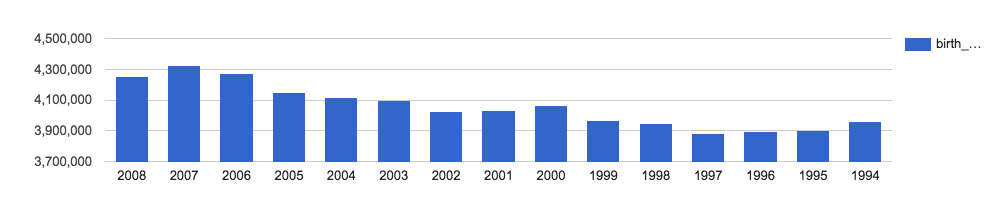

In [50]:
# 実行と可視化
%chart columns --data total_births --fields year,birth_count

In [ ]:
import google.datalab.bigquery as bq
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY  10 AND RAND() < 0.01
"""
# pandas.Dataframeでインスタンス化
df = bq.Query(sql).execute().result().to_dataframe()

In [32]:
# 可視化
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

year,birth_count
2008,4255156
2007,4324008
2006,4273225
2005,4145619
2004,4118907
2003,4096092
2002,4027376
2001,4031531
2000,4063823
1999,3963465
